In [1]:
import pandas as pd
from collections import Counter
import numpy as nm
import matplotlib.pyplot as plt
import warnings
import random
import datetime
warnings.filterwarnings("ignore")

### File Loading & Text Preprocessing

In [2]:
#data= pd.read_json("review.json", lines=True, chunksize=100000)

In [3]:
'''
i=1
for c in data:
    c.to_csv("review"+str(i)+".csv", index=False)
    i=i+1
'''   

'\ni=1\nfor c in data:\n    c.to_csv("review"+str(i)+".csv", index=False)\n    i=i+1\n'

In [4]:

df= pd.DataFrame(columns=["stars", 'text'])
for c in range(1,2):#67
    m=pd.read_csv("review"+str(c)+".csv")
    df=df.append(pd.DataFrame(m[['stars','text']]) ,ignore_index=True)
df['text']=df['text'].str.replace('\d+', '')
df= df.dropna(axis=0, how="any")
print(df.isna().sum())
import string
df['text']=df['text'].apply(lambda x:str(x).translate(str.maketrans('', '', string.punctuation)).lower().rstrip())
df['text']

stars    0
text     0
dtype: int64


0        total bill for this horrible service over gs t...
1        i adore travis at the hard rocks new kelly car...
2        i have to say that this office really has it t...
3        went in for a lunch steak sandwich was delicio...
4        today was my second out of three sessions i ha...
                               ...                        
99995    i love the clothes in aritzia the service i ca...
99996    we went here to have a small dinner with famil...
99997    amazing our  boys never had this much fun  so ...
99998    wanted a short hair cut but didnt have a regul...
99999    this place is rad dueling pianos happy hour ti...
Name: text, Length: 100000, dtype: object

In [5]:
import nltk
from nltk.corpus import stopwords
words=stopwords.words('english')
arr=[]
for el in df['text']:
    pp=''
    var=el.split()
    for i in var:
        if not i in words:
            pp=pp+i+' '
    arr.append(pp)



In [6]:
df['text']=arr

In [7]:
df['text']

0        total bill horrible service gs crooks actually...
1        adore travis hard rocks new kelly cardenas sal...
2        say office really together organized friendly ...
3        went lunch steak sandwich delicious caesar sal...
4        today second three sessions paid although firs...
                               ...                        
99995    love clothes aritzia service without one shopp...
99996    went small dinner family us waiter recommended...
99997    amazing boys never much fun much dolaser tag b...
99998    wanted short hair cut didnt regular hairstylis...
99999    place rad dueling pianos happy hour till wells...
Name: text, Length: 100000, dtype: object

### Splitting dataset into :
- positive comments
- negative comments
- neutral comments

To identify bad buzz we will work with negative

In [8]:
positive= df[df['stars']>3]

In [9]:
negative= df[df['stars']<3]

In [10]:
neutral= df[df['stars']==3]

### Selecting words that can identify positive and neutral comments
We want to avoid those words in negative comments analysis, because they can represent differnt types of comments

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
vectorizer2 = TfidfVectorizer(analyzer='word', tokenizer=LemmaTokenizer(), ngram_range=(1,2), min_df=19, max_df=0.99,max_features=300)
X2 = vectorizer2.fit_transform(positive['text'])
featpos=vectorizer2.get_feature_names()
X2 = vectorizer2.fit_transform(neutral['text'])
featneu=vectorizer2.get_feature_names()

for i in featpos:
    if not i in featneu:
        featneu.append(i)
featneu

['actually',
 'almost',
 'also',
 'although',
 'always',
 'amazing',
 'another',
 'anything',
 'appetizer',
 'area',
 'around',
 'ask',
 'asked',
 'atmosphere',
 'average',
 'away',
 'back',
 'bad',
 'bar',
 'beef',
 'beer',
 'best',
 'better',
 'big',
 'bit',
 'bread',
 'breakfast',
 'buffet',
 'burger',
 'busy',
 'came',
 'cant',
 'check',
 'cheese',
 'chicken',
 'chip',
 'choice',
 'clean',
 'close',
 'coffee',
 'cold',
 'come',
 'come back',
 'coming',
 'cooked',
 'cool',
 'could',
 'couple',
 'cream',
 'customer',
 'day',
 'decent',
 'decided',
 'definitely',
 'delicious',
 'dessert',
 'didnt',
 'different',
 'dinner',
 'disappointed',
 'dish',
 'doesnt',
 'done',
 'dont',
 'drink',
 'dry',
 'eat',
 'eating',
 'egg',
 'either',
 'else',
 'end',
 'enjoy',
 'enjoyed',
 'enough',
 'especially',
 'even',
 'ever',
 'every',
 'everything',
 'expect',
 'expensive',
 'experience',
 'extra',
 'far',
 'fast',
 'favorite',
 'feel',
 'felt',
 'find',
 'fine',
 'first',
 'fish',
 'flavor',
 'f

### Creating BOW by using TF- IDF measurments
- lemmatization
- 500 fetuares
- ngrams: 1,2
- stopwords: presented in other neutral and negative comments( as well as english stopwords that have been removed earlier)


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer  
tfidfconverter = TfidfVectorizer(tokenizer=LemmaTokenizer(), max_features=500, min_df=5, max_df=0.9, ngram_range=(1,2),stop_words=featneu)  
X = tfidfconverter.fit_transform(negative['text'])
df = pd.DataFrame(X.toarray(), columns=tfidfconverter.get_feature_names())
df

,across,add,added,additional,ago,ahead,air,along,already,amount,...,worse,worst,wow,write,wrong,yelp,yes,yet,young,zero
0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.081308,0.0,0.0,0.0,0.077583,0.0,...,0.0,0.0,0.0,0.0,0.071862,0.0,0.000000,0.082699,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
4,0.0,0.0,0.248138,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22555,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.294647,0.0,0.000000,0.000000,0.0,0.0
22556,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
22557,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
22558,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0


### Negaive comments have various topics( reason for the comments), lets try to see some general tendencies
- combine words that belongs to various topic and reduce the dimentions
- 15 topics to be chosen

In [14]:
from sklearn.decomposition import NMF, LatentDirichletAllocation


lda = LatentDirichletAllocation(n_components=15, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(X)

In [25]:
do=pd.DataFrame(index=tfidfconverter.get_feature_names())
count=0
ftrs=pd.DataFrame(index=range(1,10))
for i in lda.components_:
    
    d= pd.DataFrame(i,index=tfidfconverter.get_feature_names(),columns=[count])
    uu=pd.DataFrame(d.sort_values(by=[count],ascending=False).index[:10])
    ftrs[count]=uu
    do[count]=d
    count=count+1
      
ftrs

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,crab,thai,money,massage,nail,door,rude,office,mediocre,impressed,rude,counter,min,bean,can
2,bacon,salty,waste money,wash,phone,tire,awful,doctor,bland,club,dirty,behind,wing,mexican,not
3,onion,cook,poor,driver,manager,company,cashier,charge,priced,ticket,sale,product,seated,salsa,can not
4,pasta,bill,smell,delivered,company,avoid,attitude,company,suck,game,buy,wall,sat,burnt,sick
5,rib,bbq,cup,package,email,street,working,insurance,disappointing,frozen,lady,employee,drive,veggie,horrible
6,decor,glass,spend,tip,salon,truck,horrible,charged,bowl,son,bought,dirty,hostess,disgusting,pool
7,slice,kitchen,yelp,hand,appointment,month,seem,fee,dollar,crap,worker,bed,empty,gone,stay
8,tomato,salt,lettuce,ordering,refund,across,worst,rental,wife,credit,anymore,register,party,black,gross
9,strip,entree,rather,twice,sent,repair,serve,call,buck,school,wish,paper,thru,soggy,loud


### Topics 3D Visualization with help of TSNE

In [26]:
from sklearn.manifold import TSNE
model = TSNE(n_components = 3, perplexity = 50)
tsne_data = model.fit_transform(do)


In [27]:
from sklearn import preprocessing


min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(tsne_data)

dataV=pd.DataFrame(x_scaled, columns=["D1","D2","D3"])

for i in dataV:
    sd= 1*dataV[i].std()
    mean=dataV[i].mean()
    
    a=dataV[i].apply(lambda x:x if x> mean-sd  else mean-sd)
    dataV[i]=  a.apply(lambda x: x if  x< mean+sd  else mean+sd)

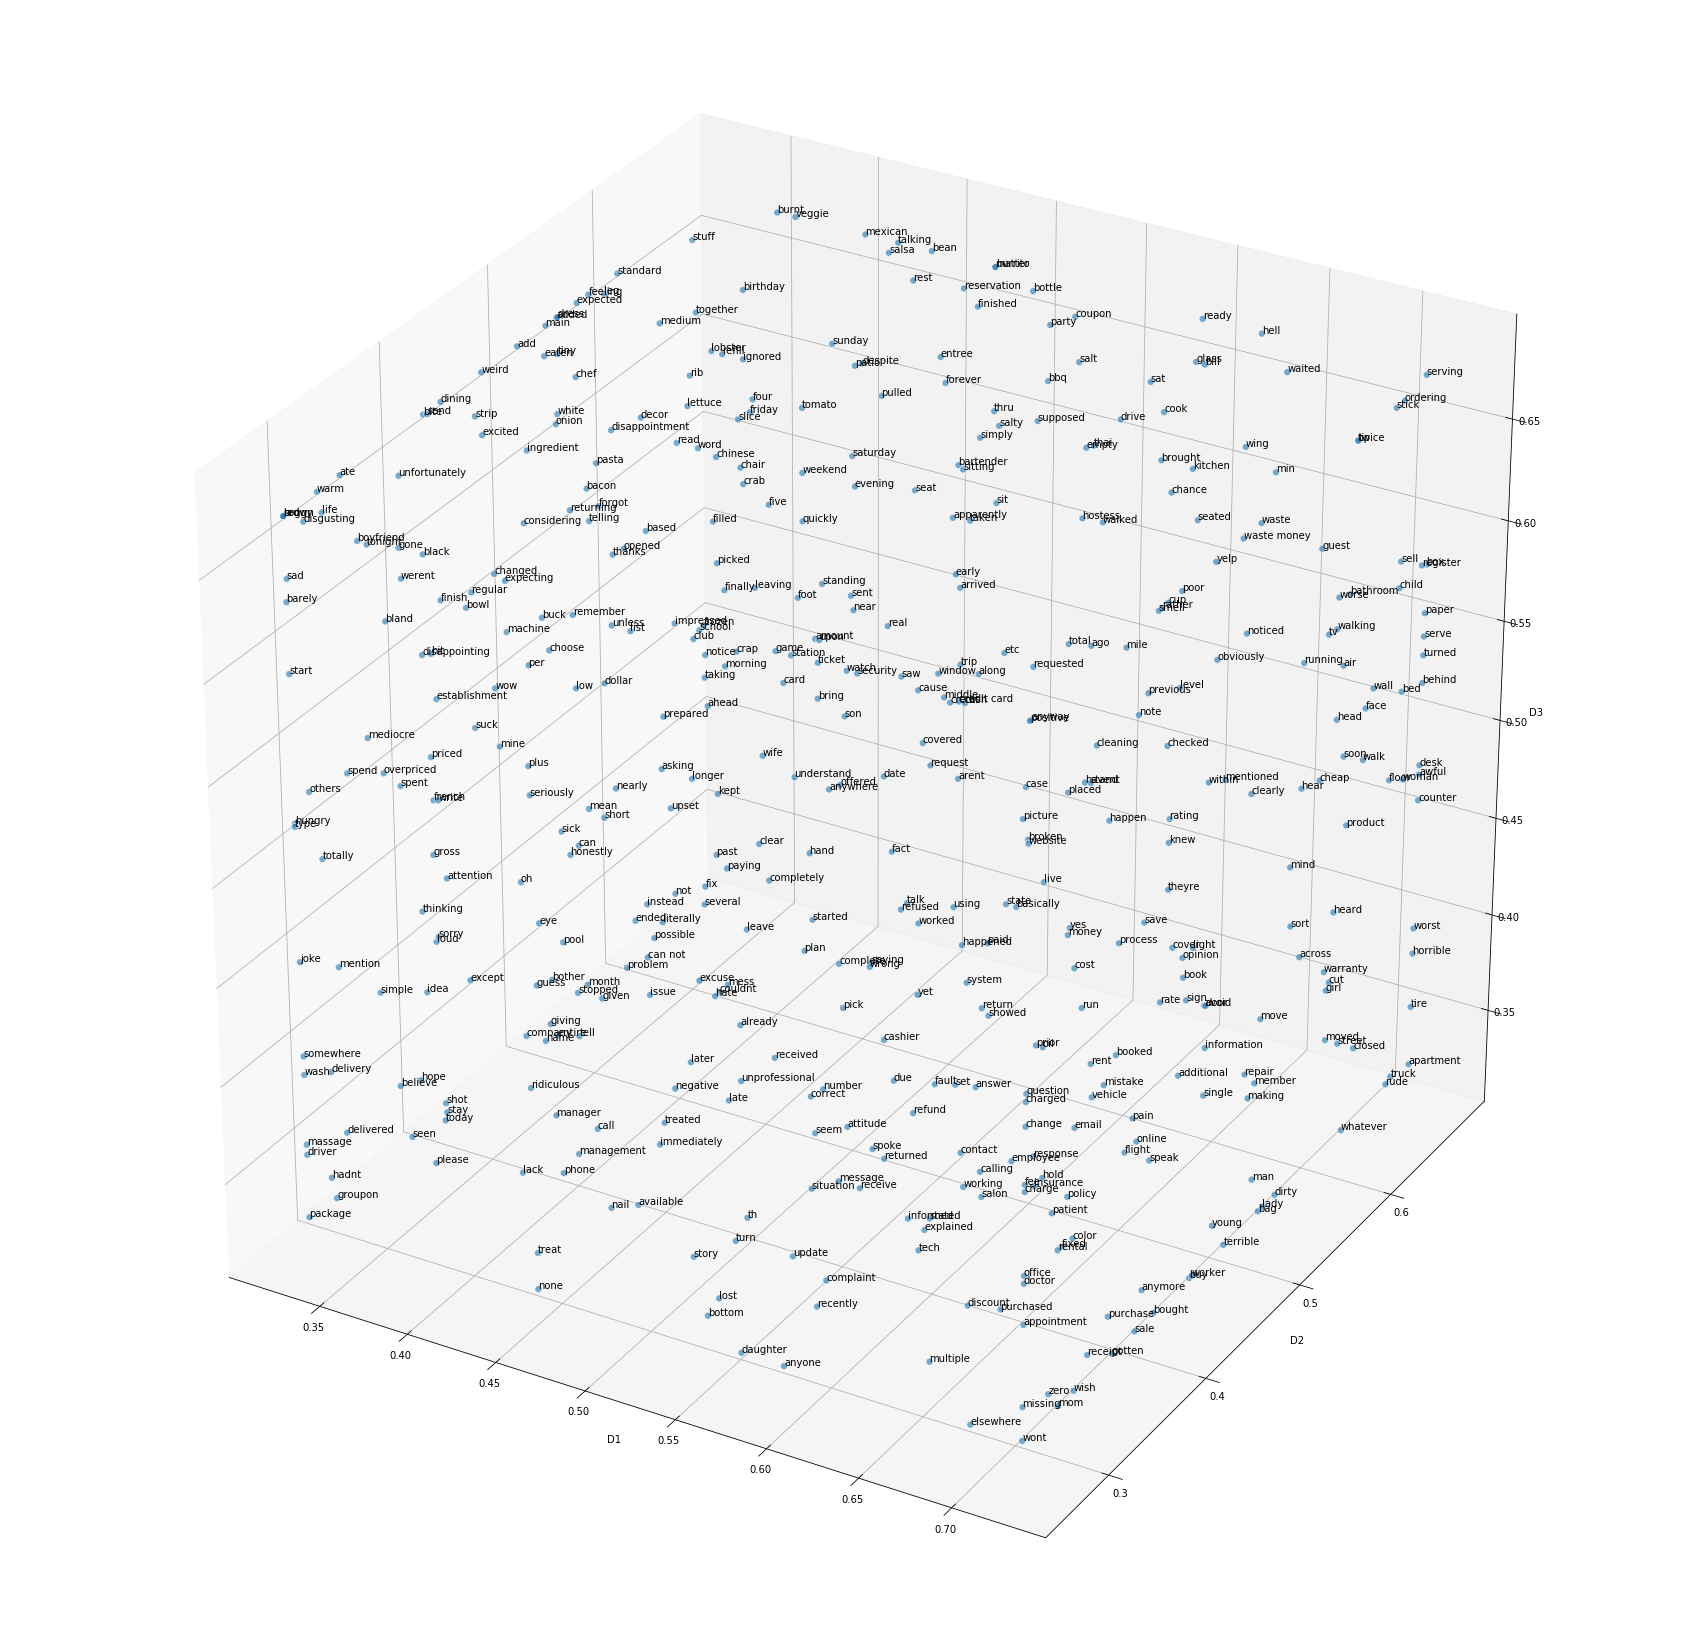

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111, projection='3d')

xs = dataV["D1"]
ys = dataV["D2"]
zs= dataV["D3"]
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

ax.set_xlabel('D1')
ax.set_ylabel('D2')
ax.set_zlabel('D3')
m=0
for  x, y, z in zip( xs, ys, zs):
    
    label = tfidfconverter.get_feature_names()[m]
    ax.text(x, y, z,  label)
    m=m+1

### BOW 3D Visualization with help of TSNE

In [29]:
from sklearn.manifold import TSNE
model = TSNE(n_components = 3, perplexity = 50)
tsne1 = model.fit_transform(X.T)


In [30]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(tsne1)

dataV1=pd.DataFrame(x_scaled, columns=["D1","D2","D3"])

for i in dataV:
    sd= 1*dataV1[i].std()
    mean=dataV1[i].mean()
    
    a=dataV1[i].apply(lambda x:x if x> mean-sd  else mean-sd)
    dataV1[i]=  a.apply(lambda x: x if  x< mean+sd  else mean+sd)

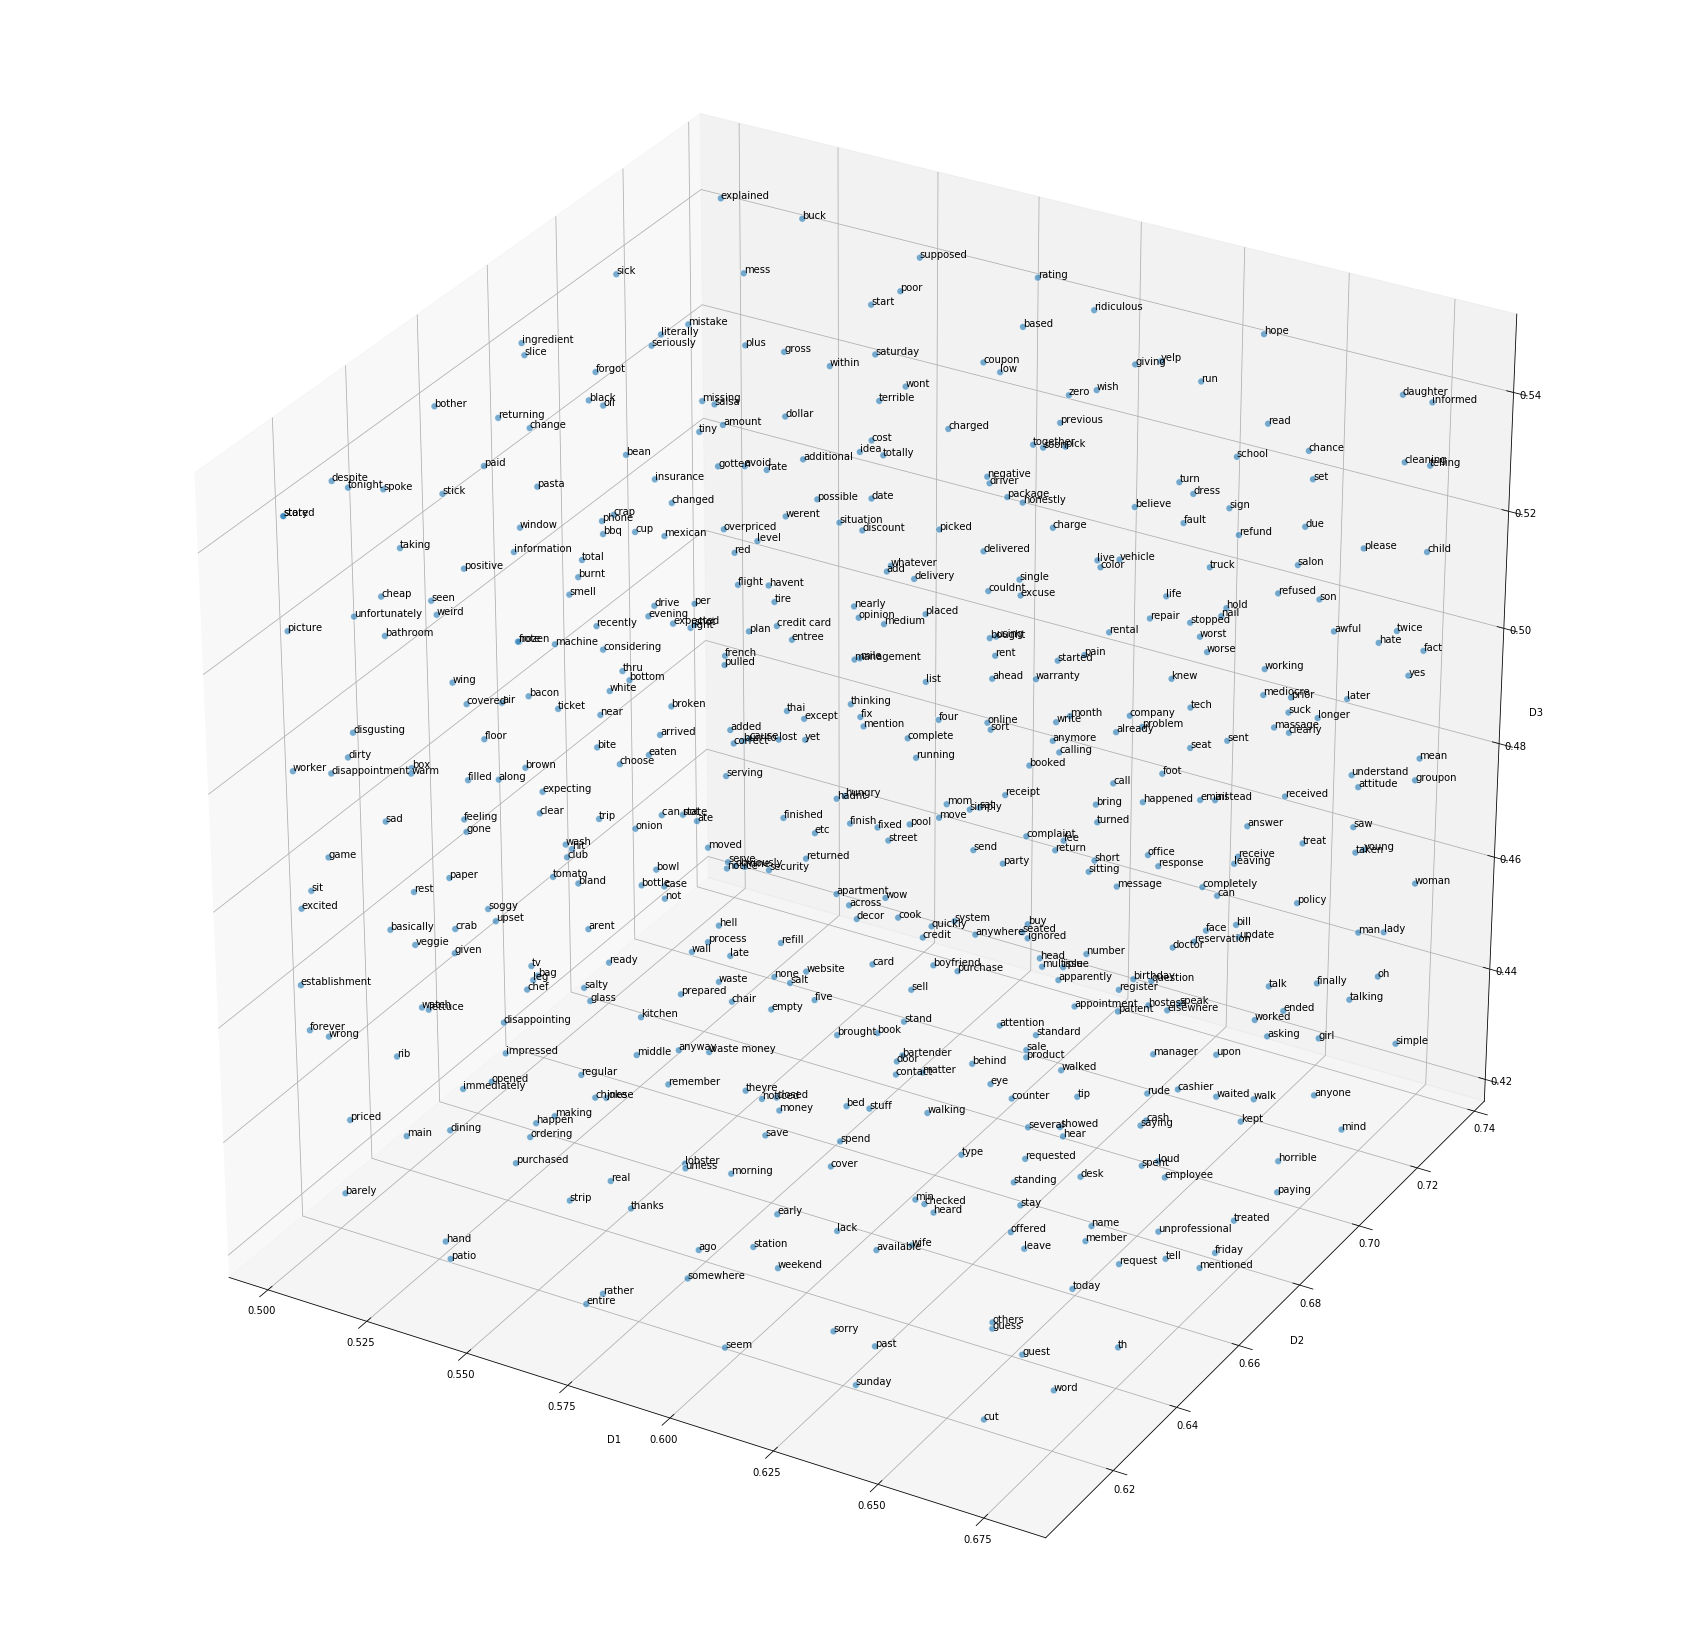

In [31]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111, projection='3d')

xs = dataV1["D1"]
ys = dataV1["D2"]
zs= dataV1["D3"]
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

ax.set_xlabel('D1')
ax.set_ylabel('D2')
ax.set_zlabel('D3')
m=0
for  x, y, z in zip( xs, ys, zs):
    
    label = tfidfconverter.get_feature_names()[m]
    ax.text(x, y, z,label)
    m=m+1

In [32]:
dataV1['fetuares']=tfidfconverter.get_feature_names()
dataV1[['fetuares',"D1"]].sort_values(by="D1",ascending=False)[:10]


,fetuares,D1
300,please,0.676786
82,cleaning,0.676786
127,due,0.676786
311,problem,0.676786
121,doctor,0.676786
225,longer,0.676786
113,desk,0.676786
227,loud,0.676786
302,policy,0.676786
201,informed,0.676786


In [33]:
dataV1['fetuares']=tfidfconverter.get_feature_names()
dataV1[['fetuares',"D2"]].sort_values(by="D2",ascending=False)[:10]


,fetuares,D2
365,seated,0.734378
91,completely,0.734378
136,entree,0.734378
124,dress,0.734378
358,sat,0.734378
361,saw,0.734378
364,seat,0.734378
374,serving,0.734378
381,sign,0.734378
97,couldnt,0.734378


In [34]:
dataV1['fetuares']=tfidfconverter.get_feature_names()
dataV1[['fetuares',"D3"]].sort_values(by="D3",ascending=False)[:10]


,fetuares,D3
499,zero,0.544312
363,school,0.544312
220,light,0.544312
375,set,0.544312
96,cost,0.544312
204,insurance,0.544312
202,ingredient,0.544312
49,bought,0.544312
380,sick,0.544312
192,hope,0.544312


In [35]:
df_idf = pd.DataFrame(tfidfconverter.idf_, index=tfidfconverter.get_feature_names(),columns=["idf_weights"])
df_idf=df_idf[df_idf["idf_weights"]>0]
df_idf.sort_values(by=["idf_weights"],ascending=True)[:40]

print(tfidfconverter.idf_)

[4.9372033  4.80140176 5.2038951  5.26507626 4.23613305 5.20686687
 5.36798622 5.1490473  4.04204335 4.60073107 4.71405975 5.03501661
 4.08472408 5.02752594 5.18043361 5.81997134 4.7994196  4.25318861
 5.1490473  4.13642546 4.52268836 4.57035303 4.90808591 4.47004463
 4.76057977 4.59425855 4.36853768 5.24323452 4.96252111 4.83571391
 4.90808591 4.87124534 4.68361873 4.99569951 5.57293958 5.11047503
 5.33024589 4.46862114 4.46294736 4.03372153 5.10777597 4.74921601
 5.15468112 4.31711569 5.38918843 5.30366625 5.02256315 5.43299105
 5.10239961 4.59264695 5.00782087 4.90588083 5.26192665 4.33437876
 5.18624758 4.10330653 5.44048172 5.35755134 5.32353446 5.37853113
 4.29176732 3.37285786 4.97424458 4.9884966  5.05016842 4.34061709
 4.92141944 5.04509227 4.86911994 5.31355101 5.33024589 4.91029585
 4.25433605 4.74733454 3.96521988 4.30014559 4.57035303 4.72871203
 5.26507626 5.19209555 5.2038951  5.26507626 5.34380542 5.15186024
 4.69425713 4.815388   5.30366625 5.4632964  3.85308955 5.0707

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer2 = CountVectorizer(tokenizer=LemmaTokenizer(),analyzer='word', ngram_range=(1, 2), min_df=2, max_df=0.9,max_features=2000, stop_words=featneu)
X2 = vectorizer2.fit_transform(negative['text'])
df = pd.DataFrame(X2.toarray(), columns=vectorizer2.get_feature_names())
df


,absolute,ac,accept,acceptable,access,accident,accommodate,accommodating,according,account,...,york,youd,youll,young,youve,yr,yuck,yummy,zero,ã
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22555,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22556,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22557,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22558,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
'''
df = pd.DataFrame(X2[0].T.todense(), index=vectorizer2.get_feature_names(), columns=["count"])
df.sort_values(by=["count"],ascending=False)[:10]
'''